<a href="https://colab.research.google.com/github/etckanikama/practice-repository/blob/main/sin_prediction01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

URLの記事を参考にsin波を予測するプログラムを作成する

[RNN-sin波予測(pytorch,numpy)](https://www.atmarkit.co.jp/ait/articles/2006/19/news023_2.html)

ゴール：この記事にあるプログラムを完璧に理解し、機械学習の実装の流れをスライドにまとめて発表することをゴールとする。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from random import uniform

# num_div:一周期を何分割するか
# cycles:周期の数
# offset:x軸（時刻）に関するオフセット
def make_data(num_div, cycles, offset=0):
    step = 2 * np.pi / num_div
    res0 = [np.sin(step * i + offset) for i in range(num_div * cycles + 1)] #2周期分の分割した正解ラベル（xのデータ）
    res1 = [np.sin(step * i + offset) + uniform(-0.02, 0.02) for i in range(num_div * cycles + 1)]# 誤差を加えたデータ
    return res0, res1

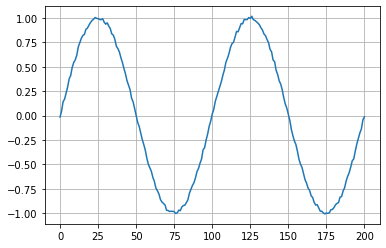

In [ ]:
num_div = 100
cycles = 2

sample_data, sample_data_w_noise = make_data(num_div, cycles)

plt.plot(sample_data_w_noise)
plt.grid()

In [17]:
# make_data関数を呼び出したうえで、生成したデータをもとにx_train,(訓練データ)と訓練ラベルx_label(y_train)に分割する
# dataとlabelに分割する
# make_data関数で作った時系列データをnum_batchパラメータに指定された数だけスライスしてデータをずらしてまとめたのが訓練データ
def make_train_data(num_div, cycles, num_batch, offset=0):
  x,x_w_noise = make_data(num_div, cycles, offset) #x:正しいsin波のデータ,x_w_noise：ノイズの入ったsin波のデータ
  data= []
  labels = []
  count = len(x) - num_batch
  # x_w_noise:ノイズ交じりのデータをnum_batchで分割
  data = [x_w_noise[idx: idx+num_batch] for idx in range(count)] #2次元
  # x:正しいデータをnum_batchで分割
  labels = [x[idx+num_batch] for idx in range(count)] #1次元

  num_items = len(data) # 176(len(data)): count = len(x)(201) - num_batch(25)
  # data(リスト型)をテンソル型に変換：データの中身は変わらない。扱いやすいように形が変わっただけ
  # train_data,とdata[0]を見てみるとわかる
  train_data = torch.tensor(data, dtype=torch.float)
  # pytorchのrnnオブジェクトに渡せるようにするために三次元にする必要がある
  # 入力する訓練データの形状：「バッチの個数xバッチのサイズ」
  train_data = train_data.reshape(num_items, num_batch,-1)
  # labelに対しても同様の処理を行う
  train_labels = torch.tensor(labels, dtype=torch.float)
  train_labels = train_labels.reshape(num_items,-1)

  # print(len(x))
  # print(count)
  # print(len(data))

  # print(len(labels))
  return train_data,train_labels
# データを（訓練データと、正解データに分ける）
x_train,t_train = make_train_data(num_div, cycles, 25)
print(x_train.shape, t_train.shape)

torch.Size([176, 25, 1]) torch.Size([176, 1])


In [80]:
# RNNを使用するネットワークの定義
# ：詳しく知らなくてもできてしまうフレームワークのよくないところ全開

"""
RNNの挙動を確認(試すときはclass定義の下に移動させる)
# 入力x:10, hidden:20,layer=2
rnn = torch.nn.RNN(10,20,2)
# print(rnn)
# 入力ｘを作成
input = torch.randn(3,1,10)
# print(input)
# hidden:h0
h0 = torch.randn(2,1,20)
output,hn = rnn(input,h0)
print(input)

numpyのスライス
[行,列]でスライスできるので、
a = np.array([[0,1,4],[2,3,5]])
print(a[:,-1]) #行全部（:）、列後ろ（-1）
"""

out_size = 1
class Net(torch.nn.Module):
  # スーパークラスmoduleクラスのNetはサブクラスであり、スーパークラスの__init__メソッドを呼び出している
  # RNNにおいてinput_size:x,hidden_size:h,num_layers:何層にするか（デフォは１）
  def __init__(self, input_size, hidden_size,num_layers=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size, hidden_size)
    # out:出力層のノード数：今回はsin波の値を１つだけ推測するから1になる
    self.fc = torch.nn.Linear(hidden_size, out_size) #hidden × out の行列：内積計算の総和
  def forward(self, x, hidden):
    # output:次の層の出力、h:現在の入力をした時点での隠れ状態を表すオブジェクト
    output, h = self.rnn(x,hidden)
    output = self.fc(output[:,-1]) #output[行全部,最後の列]=最後の列一列だけ
    return output,h









In [77]:
# 学習（ミニバッチなし）

# 初期データを分割
num_div = 100
cycles = 2
num_batch = 25
x_train, t_train = make_train_data(num_div, cycles, num_batch)

# クラスのインスタンスnetを作成
input_size = 1
hidden_size = 32
net = Net(input_size, hidden_size)

# 損失関数、最適化アルゴリズム（確率的勾配降下法(sgd)：重みの更新を行う,学習率lrを設定)
criterion = torch.nn.MSELoss() #MSE(mean squared error,平均二乗和誤差)
"""
# 要検討！！！
# 様々な評価関数（損失関数）の説明リンク：https://www.atmarkit.co.jp/ait/articles/2008/17/news031.html

# 自動で割り振った重みとバイアスを見れる&&optimizerの使い方説明
# 参考url:https://qiita.com/mathlive/items/d9f31f8538e20a102e14#6-network%E3%81%AE%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E9%96%B2%E8%A6%A7
# for param in net.parameters():
#   print(param)

# print(net.state_dict().keys())#これで層の名前を確認できる
# print(net.state_dict()['rnn.weight_hh_l0'])
"""
# 重みの更新を行う:学習率を設定
optimizer = torch.optim.SGD(net.parameters(), lr=0.05)

# print(optimizer.param_groups)



In [81]:
# 学習を行うプログラム

num_layers = 1
EPOCHS = 100

losses = []

for epoch in range(EPOCHS):
    print('epoch:', epoch, ', \n')
    optimizer.zero_grad()
    hidden = torch.zeros(num_layers, num_batch, hidden_size)
    # loss

epoch: 0 , 

epoch: 1 , 

epoch: 2 , 

epoch: 3 , 

epoch: 4 , 

epoch: 5 , 

epoch: 6 , 

epoch: 7 , 

epoch: 8 , 

epoch: 9 , 

epoch: 10 , 

epoch: 11 , 

epoch: 12 , 

epoch: 13 , 

epoch: 14 , 

epoch: 15 , 

epoch: 16 , 

epoch: 17 , 

epoch: 18 , 

epoch: 19 , 

epoch: 20 , 

epoch: 21 , 

epoch: 22 , 

epoch: 23 , 

epoch: 24 , 

epoch: 25 , 

epoch: 26 , 

epoch: 27 , 

epoch: 28 , 

epoch: 29 , 

epoch: 30 , 

epoch: 31 , 

epoch: 32 , 

epoch: 33 , 

epoch: 34 , 

epoch: 35 , 

epoch: 36 , 

epoch: 37 , 

epoch: 38 , 

epoch: 39 , 

epoch: 40 , 

epoch: 41 , 

epoch: 42 , 

epoch: 43 , 

epoch: 44 , 

epoch: 45 , 

epoch: 46 , 

epoch: 47 , 

epoch: 48 , 

epoch: 49 , 

epoch: 50 , 

epoch: 51 , 

epoch: 52 , 

epoch: 53 , 

epoch: 54 , 

epoch: 55 , 

epoch: 56 , 

epoch: 57 , 

epoch: 58 , 

epoch: 59 , 

epoch: 60 , 

epoch: 61 , 

epoch: 62 , 

epoch: 63 , 

epoch: 64 , 

epoch: 65 , 

epoch: 66 , 

epoch: 67 , 

epoch: 68 , 

epoch: 69 , 

epoch: 70 , 

epoch: 71 , 

ep